In [1]:
from genelens.fselector import FeatureSelector, get_feature_space, fsplot
from genelens import netanalyzer, enrichment
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from importlib.resources import files

In [2]:
# data load
data = pd.read_csv(files("genelens").joinpath("data/exampl_data/train_test.csv"), index_col=0)

X = data.drop('index', axis=1)
y = list(map(int, data['index'] == 'HCM'))

print(X.shape)

(145, 14830)


In [29]:
# FeatureSelector initialization
FS_model = FeatureSelector(X, y,
                           C = 0.04, 
                           C_space=np.linspace(0.0001, 1, 20), #bigger space -> more precision, more processor time
                           C_finder_iter=10,
                           cut_off_frac_estimation=False,
                           cut_off_frac_model=0.95,
                           cut_off_estim_params={'max_feature': 50}) # This parameter implements early stopping. Bigger feature space -> more precision, more processor time

In [30]:
FS_model.fit(max_iter=32000, log=True, feature_resample=10) #more max_iter -> more precision, more processor time

fit model: 100%|██████████| 32000/32000 [04:36<00:00, 115.82it/s]


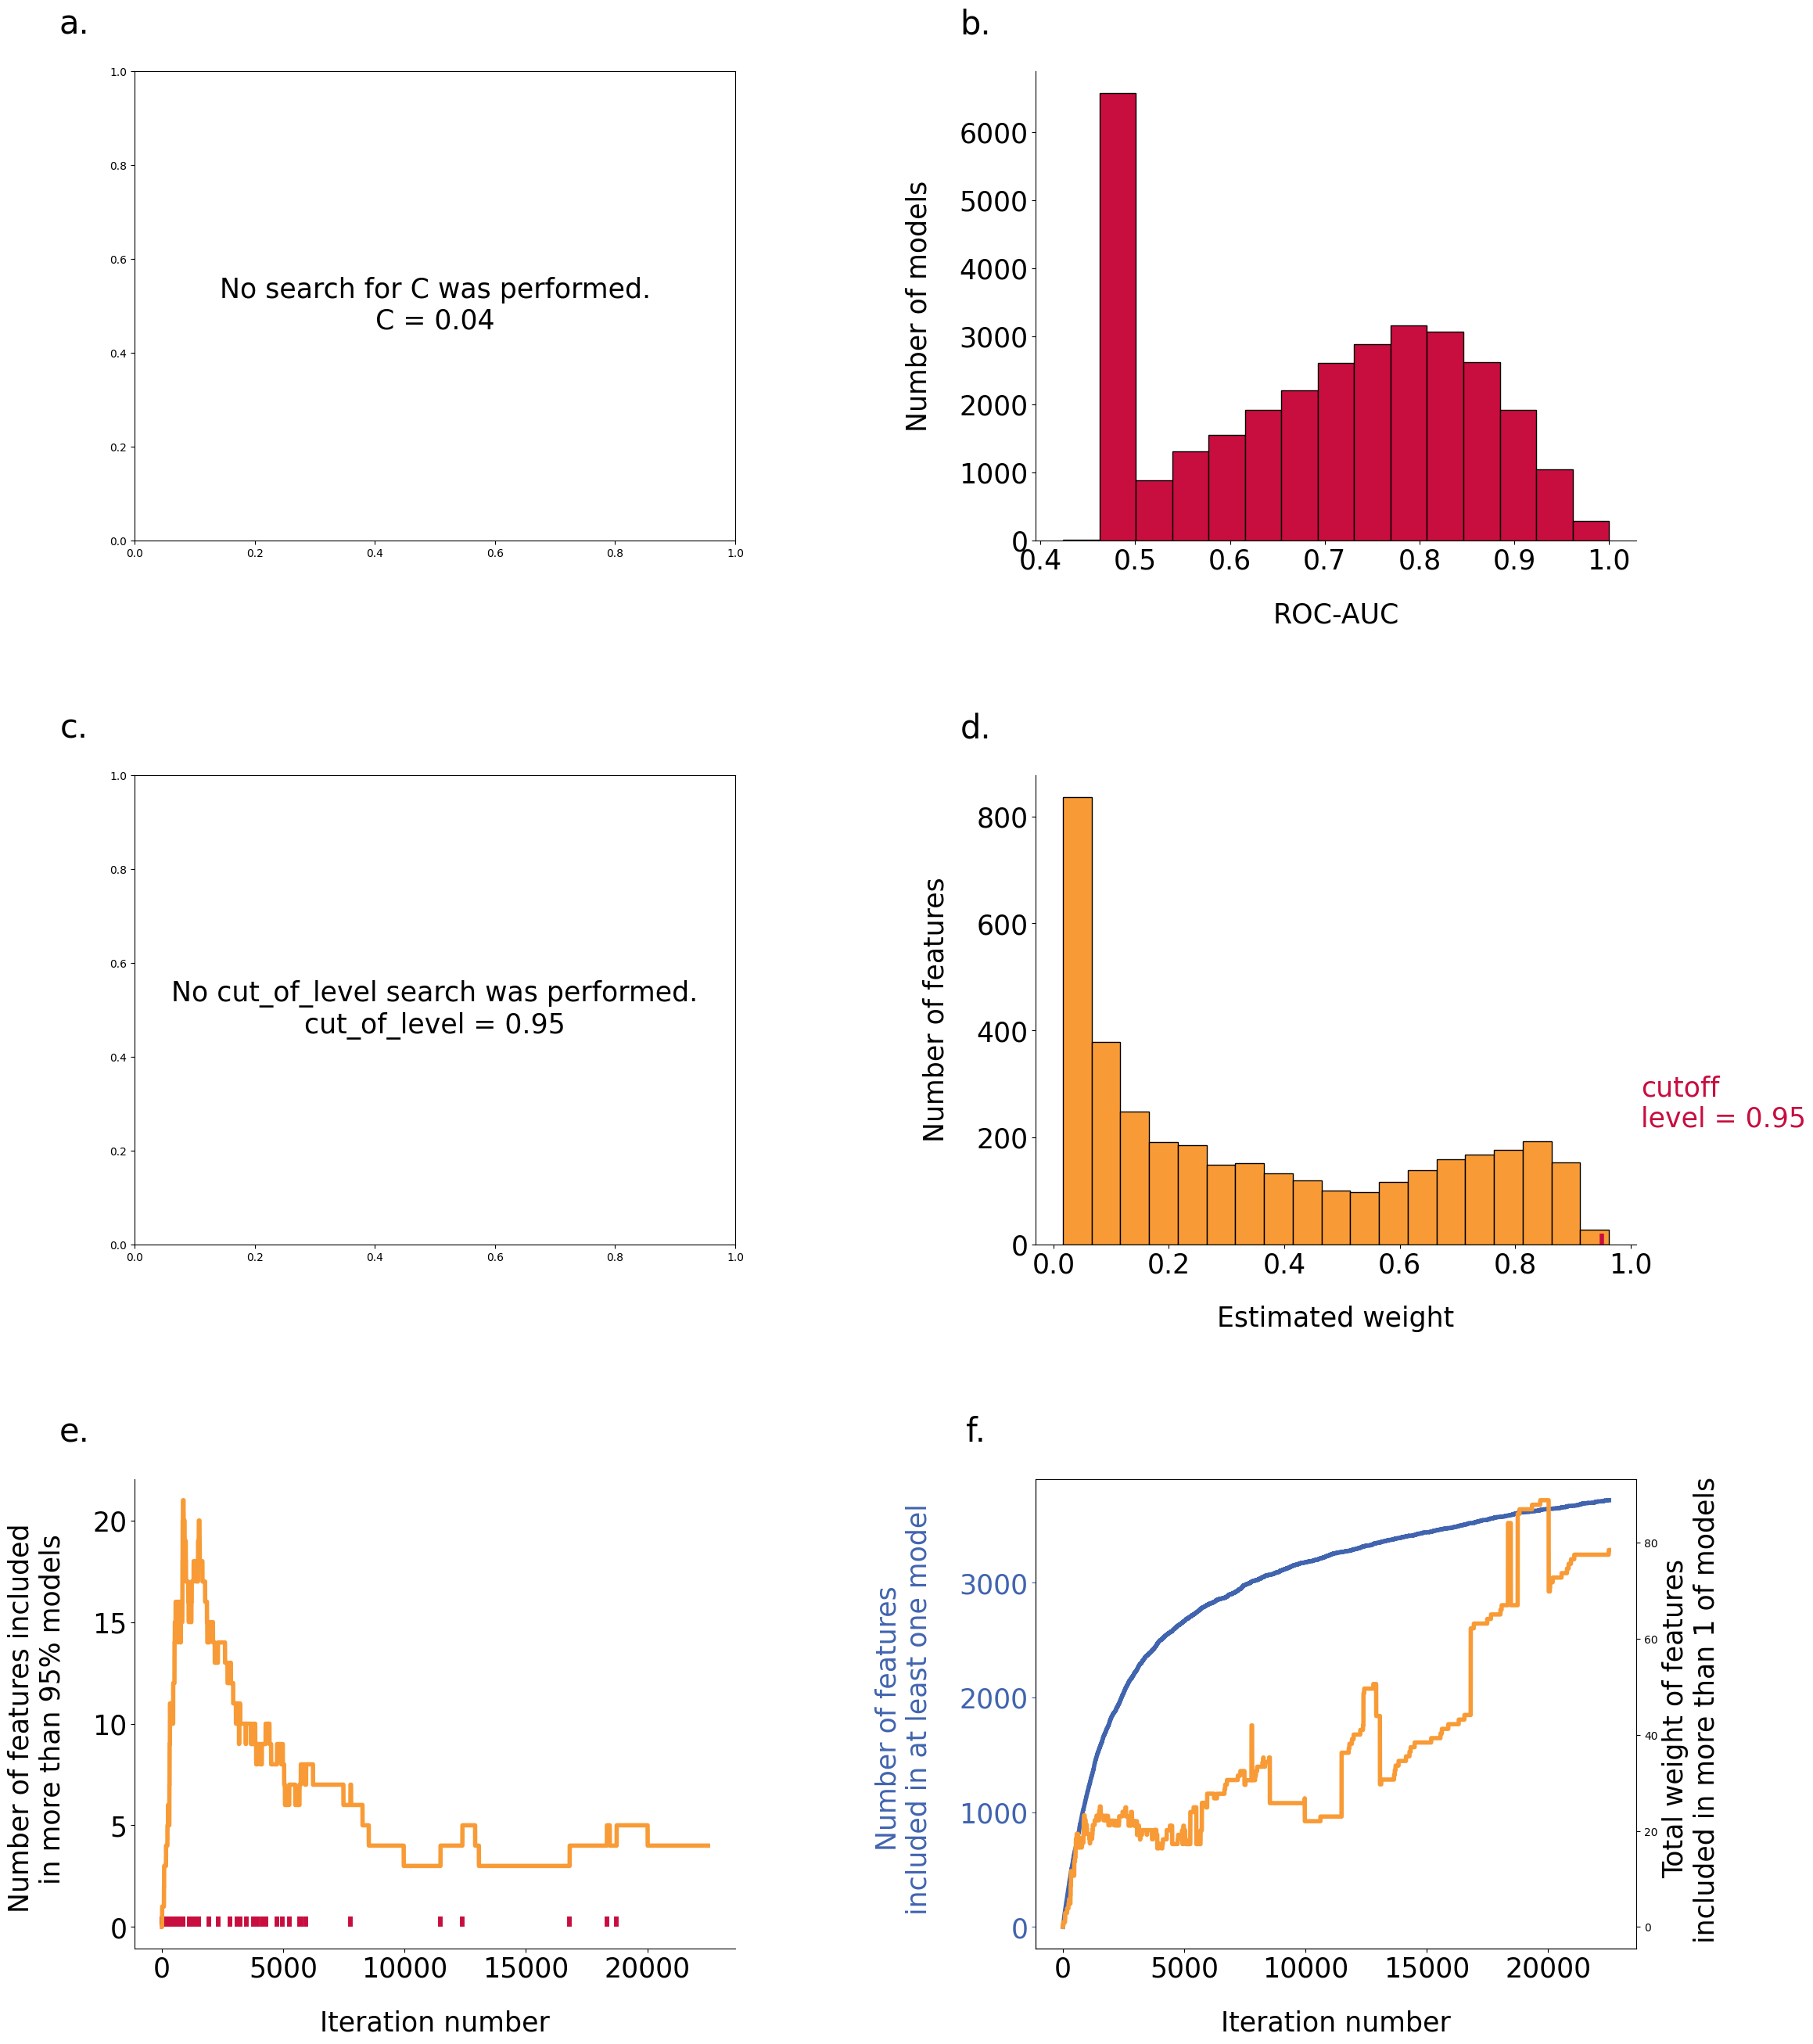

In [31]:
fsplots = fsplot(FS_model)
fsplots.plot_all(fontsize=25, labels=['a.', 'b.', 'c.', 'd.', 'e.', 'f.'], 
                left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5, wspace=0.5)
plt.show()

In [10]:
print(get_feature_space([FS_model], cut_off_level=0.95))

{'SLC16A9', 'LCP1', 'GFPT2', 'ZFP36', 'PPARG', 'DYRK1B', 'SMYD2', 'TUBA1B', 'CHST7', 'E2F4', 'LILRA2', 'SAP18', 'RAD51AP1', 'PRR16', 'POLR2G', 'IVNS1ABP', 'RHPN2', 'SERPINA3', 'UPF2', 'ZBTB25', 'EPB41L5', 'MYC', 'CARKD', 'CD209', 'C1RL', 'XPC', 'PIGO', 'YPEL2', 'CEBPD', 'SFRP4', 'ZCCHC7', 'RGS19', 'CDC42EP4', 'DHX37', 'SMARCE1', 'MYH6', 'ZMYND11'}


## Network Enrichment Analysis

In [36]:
GenGenNetwork = netanalyzer.MainNet() #Load String db and create gene-gene interaction network
GenGenNetwork.get_LCC() #get the largest connected component from the network

LCC was extracted
Total connected components=146, LCC cardinality=9844


In [37]:
GenGenNetwork.minimum_connected_subgraph(FS_model.best_features)

CDC42EP4 absent from LCC, excluded from further analysis
ZFP36 absent from LCC, excluded from further analysis
RASD1 absent from LCC, excluded from further analysis

mst-graph was extracted
Initial core feature=1, mst-graph cardinality=0


#### Two of the three selected genes are missing from the version of the String database we are using. Therefore, it is not possible to construct an mst-graph. To continue the analysis, we will select the top 10 genes sorted by their Score

In [38]:
GenGenNetwork.minimum_connected_subgraph(dict(list(FS_model.all_features.items())[:10]))

CDC42EP4 absent from LCC, excluded from further analysis
ZFP36 absent from LCC, excluded from further analysis
RASD1 absent from LCC, excluded from further analysis
YPEL2 absent from LCC, excluded from further analysis

mst-graph was extracted
Initial core feature=6, mst-graph cardinality=16


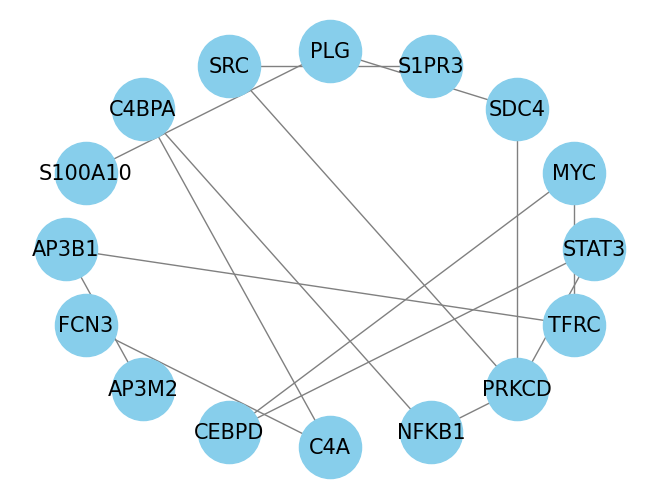

In [39]:
pos = nx.circular_layout(GenGenNetwork.mst_subgraph)

nx.draw(
    GenGenNetwork.mst_subgraph,
    pos,
    with_labels=True,       
    node_color='skyblue',   
    edge_color='gray',      
    node_size=2000,         
    font_size=15            
)

# Показываем граф
plt.show()

In [40]:
enrich_res = enrichment.reactome_enrichment(list(GenGenNetwork.mst_subgraph.nodes()), species='Homo sapiens')
enrich_res = enrichment.reac_pars(enrich_res)
G_enrich = enrichment.get_net(enrich_res) #граф сигнальных путей

reactome_df, raw_res = enrichment.dendro_reactome_to_pandas(enrich_res, G_enrich)

enrichment.get_dendro(reactome_df, FS_model.all_features)

similarity_matrix is empty. No intersections found. Dendrogram could not be constructed.


,Pathway identifier,Pathway name,#Entities found,#Entities total,Entities ratio,Entities pValue,Entities FDR,#Reactions found,#Reactions total,Reactions ratio,Species identifier,Species name,Submitted entities found,Mapped entities,Found reaction identifiers


In [1]:
from genelens import netanalyzer, enrichment

In [2]:
miRTargts = netanalyzer.Targets()

path_to_miRTarBase not specified. miRTarbase built-in version loaded


In [3]:
len(miRTargts.miR_dict.keys())

2599

In [4]:
import networkx as nx
myG = netanalyzer.MainNet()
myG.get_LCC()
print(len(list(nx.connected_components(myG.LCC))))
print(len(list(nx.connected_components(myG.G))))


LCC was extracted
Total connected components=146, LCC cardinality=9844
1
146


In [ ]:
myG.get_LCC()


LCC was extracted
Total connected components=159, LCC cardinality=111


1

In [18]:
nx.average_shortest_path_length(myG.LCC)

3.6355446355446355

In [4]:
myG = netanalyzer.MainNet()
target_nodes = miRTargts.miR_dict['hsa-miR-375']
myG.select_nodes(target_nodes, mst_LCC=False)
myG.get_LCC()

LCC was extracted
Total connected components=159, LCC cardinality=111


In [5]:
kne = netanalyzer.KeyNodesExtractor()

In [6]:
 # creating an object for extracting key nodes and storing their meta information
kne(myG)

{'TP53': 0.43590029377747985,
 'RHOA': 0.404960234624833,
 'MAPK3': 0.32172525406405017,
 'PAFAH1B1': 0.31805445319206777,
 'MYC': 0.31390933753637096,
 'PIK3CA': 0.2952561045304718,
 'HSP90AA1': 0.2677288364855196,
 'CTNNB1': 0.25452087620320574,
 'CDC42': 0.21529814153322227,
 'YWHAZ': 0.19389818583069154,
 'PRKCA': 0.16410412333473215}

In [8]:
for node in netanalyzer.KeyNodesExtractor(myG):
    print(node)

In [5]:
key_nodes

dict_keys(['TP53', 'RHOA', 'MAPK3', 'PAFAH1B1', 'MYC', 'PIK3CA', 'HSP90AA1', 'CTNNB1', 'CDC42', 'YWHAZ', 'PRKCA'])

In [20]:
from scipy.ndimage import gaussian_filter1d
class KeyNodesExtractor:
    def __init__(self, MirNet):
        self.key_nodes = dict()
        if not MirNet.LCC:
            MirNet.get_LCC()
        self.node_centrality = MirNet.get_LCCnd_centrality()
        self.graph_features = {
            'card_LCC': [len(MirNet.LCC.nodes())],
            'n_CC': [len(list(nx.connected_components(MirNet.LCC)))],
            'transitivity': [nx.transitivity(MirNet.LCC)],
            'sh_path': [nx.average_shortest_path_length(MirNet.LCC) / len(MirNet.LCC.nodes())]
        }
        
        # Автоматически выполняем извлечение при инициализации
        self._perform_extraction(MirNet)

    @staticmethod
    def inflection_finder(card_LCC, n_CC, sigma):
        y = gaussian_filter1d(card_LCC, sigma=sigma)
        dy = np.diff(y)
        idx_max_dy = np.argmax(dy)
        if card_LCC[idx_max_dy] > n_CC[idx_max_dy]:
            return KeyNodesExtractor.inflection_finder(card_LCC, n_CC, sigma + 0.2)
        return idx_max_dy

    def _perform_extraction(self, MirNet):
        """Внутренний метод для выполнения извлечения ключевых узлов"""
        for k, v in self.node_centrality.items():
            if v == 0 or len(MirNet.LCC.nodes()) == 1:
                break
            MirNet.LCC.remove_node(k)
            LCC_current = max(nx.connected_components(MirNet.LCC), key=len)
            
            self.graph_features['card_LCC'].append(len(LCC_current))
            self.graph_features['n_CC'].append(nx.number_connected_components(MirNet.LCC))
            self.graph_features['transitivity'].append(nx.transitivity(MirNet.LCC.subgraph(LCC_current)))
            self.graph_features['sh_path'].append(
                nx.average_shortest_path_length(MirNet.LCC.subgraph(LCC_current)) / len(LCC_current))

        idx_max_dy = self.inflection_finder(
            card_LCC=self.graph_features['card_LCC'],
            n_CC=self.graph_features['n_CC'],
            sigma=0.0001
        )

        self.graph_features['cutoff_point'] = idx_max_dy
        self.key_nodes = {
            node: self.node_centrality[node] 
            for i, node in enumerate(self.node_centrality) 
            if i <= idx_max_dy
        }

    def __iter__(self):
        """Позволяет итерироваться по ключевым узлам напрямую"""
        return iter(self.key_nodes)

    def keys(self):
        """Возвращает ключевые узлы"""
        return self.key_nodes.keys()

In [21]:
key_nodes = list(KeyNodesExtractor(G))

ValueError: attempt to get argmax of an empty sequence

#### The color gradient from gray to red in the signatures reflects the increase in the weight of genes according to their calculated Score. The redder the signature, the higher the weight.